###  Protein classification using RandomForest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df1 = pd.read_csv('Data/pdb_data_no_dups.csv')
df2 = pd.read_csv('Data/pdb_data_seq.csv')

df = pd.merge(df1,df2[['structureId','chainId','sequence']], on='structureId', how='inner')
df.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


Total number of protein classes

In [3]:
df = df[df['macromoleculeType'] == "Protein"]
print(df.shape)
len(df[df['macromoleculeType'] == "Protein"]['classification'].value_counts())

(346325, 16)


4468

Missing values per column in percentage

In [4]:

for i, v in df.isnull().sum().items():
    print(i, " : ", round((v/471149)*100, 1))

structureId  :  0.0
classification  :  0.0
experimentalTechnique  :  0.0
macromoleculeType  :  0.0
residueCount  :  0.0
resolution  :  3.4
structureMolecularWeight  :  0.0
crystallizationMethod  :  22.4
crystallizationTempK  :  21.7
densityMatthews  :  8.2
densityPercentSol  :  8.2
pdbxDetails  :  11.0
phValue  :  18.5
publicationYear  :  10.8
chainId  :  0.0
sequence  :  0.0


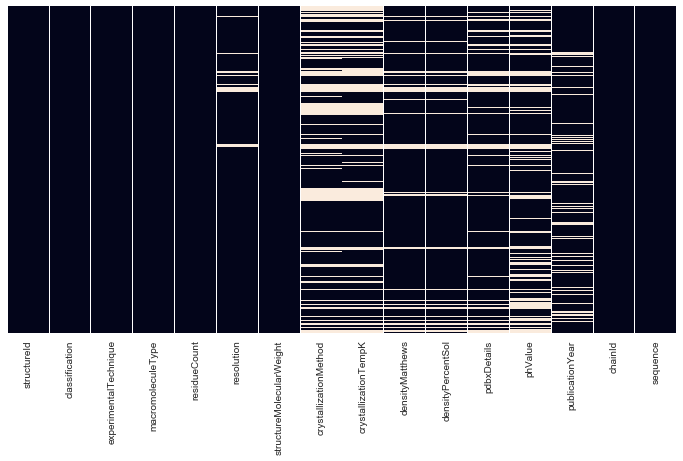

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), yticklabels=False,cbar=False)
plt.show()

In [6]:

df = df[df['macromoleculeType'] == "Protein"]
df.reset_index(inplace=True, drop=True)
df['classification'] = df['classification'].str.lower()
df['classification'] = df['classification'].str.replace('(', '/')
df['classification'] = df['classification'].str.replace(',', '/')
df['classification'] = df['classification'].str.replace(', ', '/')
df['classification'] = df['classification'].str.replace('/ ', '/')
df['classification'] = df['classification'].str.replace(')', '')
# pattern = '|'.join([', ', ',', '('])
# df['classification'] = df['classification'].str.replace(pattern, '/')

df.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


Deleting outliar 23 values for <b>Molecular weight</b> which was for Virus classification. It was a very small number so was deleted.

<b> Note: </b> Molecular weight is calculated using sequence using the weight of each amino acid. Thus, if sequence is long, then it can have large weight


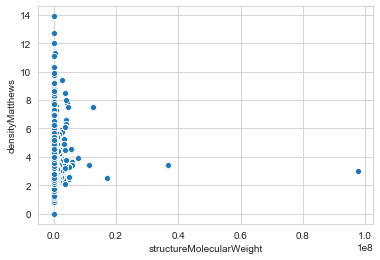

In [7]:
sns.scatterplot(x="structureMolecularWeight", y="densityMatthews", data=df)

# Later check: You can compare weight with sequence length

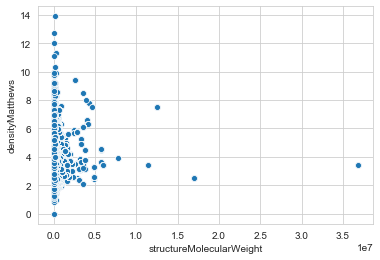

In [8]:
#density_weight = df[['classification','densityMatthews','structureMolecularWeight']].dropna().copy()
weight_max = df['structureMolecularWeight'] == df['structureMolecularWeight'].max()
df = df[~weight_max].copy()
sns.scatterplot(x="structureMolecularWeight", y="densityMatthews", data=df)

Dealing with outliar of phValue. 

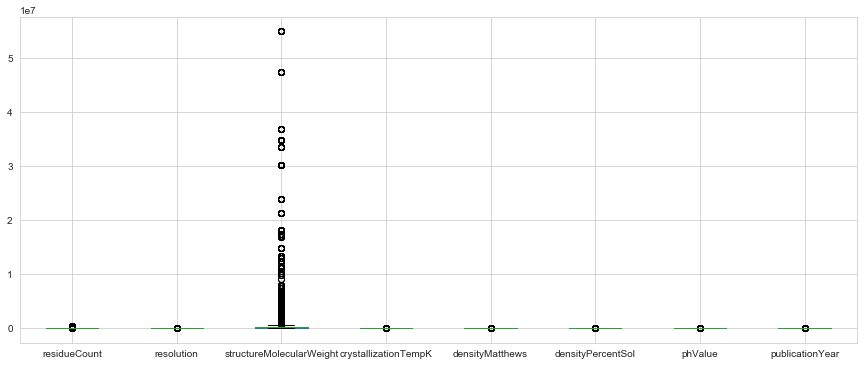

In [9]:
phvalues = df['phValue'].dropna()
df.boxplot(figsize=(15,6))

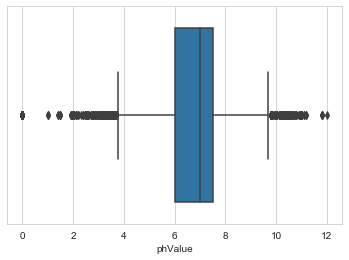

In [10]:
df['phValue'] = df['phValue'].replace(100, np.nan)
sns.boxplot(df['phValue'].dropna())

In [11]:
df.phValue.isnull().sum()

87203

In [12]:
df.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence'],
      dtype='object')

In [13]:
df.drop(['crystallizationMethod','crystallizationTempK', 'publicationYear', 'pdbxDetails'], axis=1, inplace=True) 
df.dropna(subset=['densityMatthews','densityPercentSol','resolution', 'sequence'], inplace=True)

Filter dataset's records for classification types which are > 100

In [14]:
counts = df['classification'].value_counts()

types = np.asarray(counts[(counts > 100)].index)

data = df[df.classification.isin(types)].copy()
data.head(3)

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,chainId,sequence
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,3.09,60.20,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,Protein,165,1.74,18926.61,2.75,55.28,NaN,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,3.09,60.20,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [15]:
data.phValue.isnull().sum()

44748

Handling Outliar of PhValue

In [16]:
class_dict = dict()
count = 0

classes = data['classification'].value_counts().items()

for cat, num in classes:
    
    # Remove all other classes that have number of values are less than 100
    if num < 100:
        temp = data['classification'] == cat
        data = data[~temp].copy()
        continue
        
    # Remove all a class if all phValues are null
    if data[(data['classification'] == cat) & (data['phValue'].notnull())].phValue.count() == 0:
        temp = data['classification'] == cat
        data = data[~temp].copy()
        continue
    
    ph_mean = round(data[data['classification'] == cat]['phValue'].dropna().mean(),2)
    data.loc[(data['classification'] == cat) & (data['phValue'].isna()),'phValue'] = ph_mean
    
    
    
    if num >= 100:
        class_dict[cat] = count
        count += 1

class_dict

{'hydrolase': 0,
 'transferase': 1,
 'oxidoreductase': 2,
 'immune system': 3,
 'hydrolase/hydrolase inhibitor': 4,
 'lyase': 5,
 'transcription': 6,
 'transport protein': 7,
 'viral protein': 8,
 'isomerase': 9,
 'signaling protein': 10,
 'ligase': 11,
 'structural genomics/unknown function': 12,
 'transferase/transferase inhibitor': 13,
 'protein binding': 14,
 'membrane protein': 15,
 'sugar binding protein': 16,
 'chaperone': 17,
 'structural protein': 18,
 'dna binding protein': 19,
 'cell adhesion': 20,
 'electron transport': 21,
 'metal binding protein': 22,
 'unknown function': 23,
 'cell cycle': 24,
 'toxin': 25,
 'protein transport': 26,
 'photosynthesis': 27,
 'oxidoreductase/oxidoreductase inhibitor': 28,
 'rna binding protein': 29,
 'de novo protein': 30,
 'gene regulation': 31,
 'hormone': 32,
 'viral protein/immune system': 33,
 'virus': 34,
 'apoptosis': 35,
 'metal transport': 36,
 'fluorescent protein': 37,
 'transcription regulator': 38,
 'biosynthetic protein': 39,


In [17]:
data['class'] = data['classification'].map(class_dict)
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,chainId,sequence,class
0,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,3.09,60.2,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,40
2,102M,oxygen transport,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,3.09,60.2,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,40
4,103M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,3.09,60.3,9.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,40
7,104M,oxygen transport,X-RAY DIFFRACTION,Protein,153,1.71,18030.63,1.87,34.3,7.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,40
8,105M,oxygen transport,X-RAY DIFFRACTION,Protein,153,2.02,18030.63,1.83,33.0,9.0,A,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,40


In [18]:
data.isnull().sum()

structureId                 0
classification              0
experimentalTechnique       0
macromoleculeType           0
residueCount                0
resolution                  0
structureMolecularWeight    0
densityMatthews             0
densityPercentSol           0
phValue                     0
chainId                     0
sequence                    0
class                       0
dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279138 entries, 0 to 346324
Data columns (total 13 columns):
structureId                 279138 non-null object
classification              279138 non-null object
experimentalTechnique       279138 non-null object
macromoleculeType           279138 non-null object
residueCount                279138 non-null int64
resolution                  279138 non-null float64
structureMolecularWeight    279138 non-null float64
densityMatthews             279138 non-null float64
densityPercentSol           279138 non-null float64
phValue                     279138 non-null float64
chainId                     279138 non-null object
sequence                    279138 non-null object
class                       279138 non-null int64
dtypes: float64(5), int64(2), object(6)
memory usage: 29.8+ MB


In [20]:
data.describe()

,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,class
count,279138.000000,279138.000000,2.791380e+05,279138.000000,279138.000000,279138.000000,279138.000000
mean,1691.767968,2.299487,1.951357e+05,2.754693,52.753233,6.798223,13.875259
std,2860.612908,0.646386,4.275491e+05,0.731753,10.085397,1.136427,22.570828
min,4.000000,0.480000,4.685500e+02,0.000000,0.000000,0.000000,0.000000
25%,424.000000,1.900000,4.781699e+04,2.280000,45.800000,6.300000,1.000000
50%,844.000000,2.200000,9.559023e+04,2.560000,51.890000,6.830000,4.000000
75%,1760.000000,2.660000,1.977836e+05,3.020000,59.240000,7.500000,16.000000
max,57792.000000,9.100000,3.683173e+07,13.890000,90.330000,12.000000,138.000000


## Building a model

In [21]:
X = data[['residueCount','resolution','structureMolecularWeight','densityMatthews','densityPercentSol','phValue']]
y = data['class']

In [22]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)

m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
m.fit(X_train, y_train)

predictions = m.predict(X_test)

In [23]:
print(classification_report(y_test, predictions))
print("Accuracy :",accuracy_score(y_test, predictions),'\n')

              precision    recall  f1-score   support

           0       0.78      0.92      0.84      8685
           1       0.80      0.90      0.85      7035
           2       0.90      0.92      0.91      6551
           3       0.88      0.95      0.92      3075
           4       0.94      0.93      0.93      2674
           5       0.94      0.88      0.91      2281
           6       0.86      0.87      0.86      1659
           7       0.90      0.83      0.86      1402
           8       0.94      0.90      0.92      1304
           9       0.93      0.79      0.85      1252
          10       0.87      0.81      0.84      1131
          11       0.94      0.79      0.86       947
          12       0.89      0.73      0.80       928
          13       0.88      0.77      0.82       880
          14       0.90      0.83      0.86       861
          15       0.93      0.86      0.89       716
          16       0.92      0.81      0.86       699
          17       0.95    

In [28]:
# features = ['residueCount','resolution','structureMolecularWeight','densityMatthews','densityPercentSol','phValue']
# for f in features:
#     df_subs = X.drop(f, axis=1)
#     X_train, X_test, y_train, y_test =train_test_split(df_subs, y, test_size=0.2, random_state=42)
#     m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)
#     m.fit(X_train, y_train)
#     predictions = m.predict(X_test)
#     print(f, " :",accuracy_score(y_test, predictions),'\n')

## Cross Validation

In [25]:
from sklearn.model_selection import cross_val_score, KFold
#from sklearn.nei

In [26]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, n_jobs=-1)

In [30]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

In [31]:
scores = cross_val_score(m, X, y, cv=kfold)
print(scores)

[0.88747582 0.88872967 0.88572043 0.88962528 0.88743999 0.88905209
 0.88747582 0.88615032 0.88937054 0.88740014]


In [32]:
print(scores.mean())

0.8878440093525841


In [ ]:
# Currently wroking on other models
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))

In [ ]:
#pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 4000)
